In [126]:
from defs.storage_locs import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from tools.image_extract import read_frame
from sklearn.cluster import DBSCAN
from skimage.filters import threshold_otsu, try_all_threshold, threshold_multiotsu

In [127]:
class Point():
    def __init__(self, x,y):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return f"Point({self.x},{self.y})"
    
    def values(self):
        return (self.x, self.y)

class Line():
    def __init__(self, x1,y1,x2,y2):
        self.x1 = min(x1,x2)
        self.y1 = min(y1,y2)
        self.x2 = max(x1,x2)
        self.y2 = max(y1,y2)
        self.point1 = Point(x1,y1)
        self.point2 = Point(x2,y2)

        self.slope = (y2-y1)/(x2-x1)
        self.length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        self.angle = np.arctan2(y2-y1, x2-x1)
    
    def intersect(self, other_line):
        A = self.point1
        B = self.point2
        C = other_line.point1
        D = other_line.point2
        a1 = B.y - A.y
        b1 = A.x - B.x
        c1 = a1*(A.x) + b1*(A.y)
    
        # Line CD represented as a2x + b2y = c2
        a2 = D.y - C.y
        b2 = C.x - D.x
        c2 = a2*(C.x) + b2*(C.y)
    
        determinant = a1*b2 - a2*b1
    
        if (determinant == 0):
            return Point(10**9, 10**9)
        else:
            x = (b2*c1 - b1*c2)/determinant
            y = (a1*c2 - a2*c1)/determinant
            return Point(x, y)
        
    def __repr__(self):
        return f"Line({self.x1},{self.y1},{self.x2},{self.y2})"


0


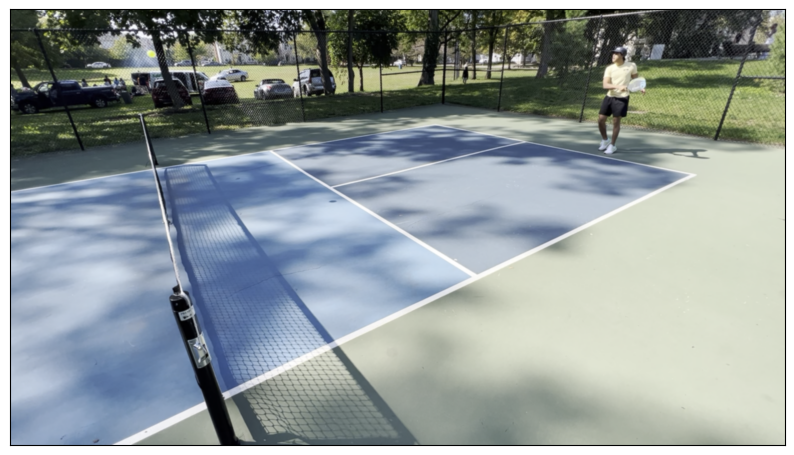

In [173]:
video_type = 'game'
video_type = 'court'
video_name = 'right_game_footage'
video_name = 'center_left_3_sunglare'
frame_num = np.random.randint(10000, 20000)
frame_num = np.random.randint(0, 1000)
frame_num = 0
print(frame_num)
img_0 = read_frame(raw_video_path(video_type, video_name), frame_num)
img_0 =  cv2.imread('/mnt/f/SeniorProject/court_photos/shady_court.png')
img_0 = cv2.cvtColor(img_0, cv2.COLOR_BGR2RGB)
# img_0 = read_frame('/mnt/f/SeniorProject/full_footage/court/center_left_rainy_1.mp4', frame_num)
img_0 = cv2.GaussianBlur(img_0, (5,5), 0)
plt.figure(figsize=(10,10))
plt.imshow(img_0)
plt.xticks([])
plt.yticks([])
plt.show()

In [170]:
def normalize_image(img):
    normalized = skimage.exposure.equalize_hist(img)
    return normalized

def diff_max_mask(img, threshold = 0.04):
    new_img = img.copy()
    new_img[:,:,0] = np.abs(img[:,:,0] - img[:,:,1])
    new_img[:,:,1] = np.abs(img[:,:,1] - img[:,:,2])
    new_img[:,:,2] = np.abs(img[:,:,2] - img[:,:,0])
    new_img = np.max(new_img, axis=2)
    show_image(new_img)
    thresholds = threshold_multiotsu(new_img, classes=6, nbins = 100)
    print(thresholds)
    # figure, ax = try_all_threshold(new_img, figsize=(20,20), verbose=False)
    # plt.show()
    
    plt.hist(new_img.reshape(-1), bins=100)
    # plot threshold lines
    for t in thresholds:
        plt.axvline(t, color='r')
    plt.show()
    return new_img <= thresholds[1] * 0.5 + thresholds[0] * 0.5
    return new_img <= threshold

def diff_from_avg_mask(img, threshold = 0.04):
    avg = np.mean(img, axis=2)
    diffs = np.square(img - np.expand_dims(avg, axis=2))/(np.expand_dims(avg, axis=2) + 1e-10)
    geom_distance = np.sqrt(np.sum(diffs, axis=2)/3)/avg
    geom_distance = np.clip(geom_distance, 0, 1)
    show_image(geom_distance)
    thresholds = threshold_multiotsu(geom_distance, classes=6, nbins = 100)
    print(thresholds)
    
    plt.hist(geom_distance.reshape(-1), bins=100)
    # plot threshold lines
    for t in thresholds:
        plt.axvline(t, color='r')
    plt.show()
    return geom_distance <= thresholds[1] * 0 + thresholds[0] * 1
    return geom_distance <= threshold

def brightness_mask(img, threshold = 0.8):
    brightness = np.mean(img, axis=2)
    show_image(1-brightness)
    thresholds = threshold_multiotsu(1-brightness, classes=6, nbins = 100)
    print(thresholds)
    
    plt.hist(1-brightness.reshape(-1), bins=100)
    # plot threshold lines
    for t in thresholds:
        plt.axvline(t, color='r')
    plt.show()
    return 1-brightness <= thresholds[1] * 0 + thresholds[0] * 1
    return brightness >= threshold

def show_image(img, size = (10,10), title = None):
    plt.figure(figsize=size)
    plt.imshow(img, cmap='gray')
    if title is not None:
        plt.title(title)
    # turn off axes
    plt.xticks([])
    plt.yticks([])
    plt.show()

def erode_mask(mask, kernel_size = (3,3), iterations = 1, shape = cv2.MORPH_RECT):
    kernel = cv2.getStructuringElement(shape, kernel_size)
    return cv2.erode(mask.astype(np.uint8), kernel, iterations=iterations)

def dilate_mask(mask, kernel_size = (3,3), iterations = 1, shape = cv2.MORPH_RECT):
    kernel = cv2.getStructuringElement(shape, kernel_size)
    return cv2.dilate(mask.astype(np.uint8), kernel, iterations=iterations)

def remove_small_objects(mask, min_size = 100, connectivity = 2):
    return skimage.morphology.remove_small_objects(mask.astype(bool), min_size=min_size, connectivity=connectivity)

def get_predicted_points(img, max_threshold = 0.04, avg_threshold = 0.04, bright_threshold = 0.8,):

    img = normalize_image(img)
    max_mask = diff_max_mask(img, threshold = max_threshold)
    avg_mask = diff_from_avg_mask(img, threshold = avg_threshold)
    bright_mask = brightness_mask(img, threshold = bright_threshold)
    mask = max_mask & avg_mask & bright_mask
    # mask = dilate_mask(max_mask) & dilate_mask(avg_mask) & dilate_mask(bright_mask)
    show_image(max_mask)
    show_image(avg_mask)
    show_image(bright_mask)
    show_image(mask)

    # clean noise
    mask = dilate_mask(mask, kernel_size=(3,3), iterations=2) 
    # mask = remove_small_objects(mask, min_size=1000, connectivity = 2)
    # mask = remove_small_objects(mask, min_size=2000, connectivity = 2)
    mask = dilate_mask(mask, kernel_size=(3,3), iterations=2)
    remainder = erode_mask(mask, kernel_size = (5,5), shape=cv2.MORPH_RECT, iterations = 5)
    remainder = dilate_mask(remainder, kernel_size = (5,5), shape=cv2.MORPH_RECT, iterations = 3)
    mask = mask * (1-remainder)
    mask = erode_mask(mask, kernel_size=(3,3), iterations=4, shape=cv2.MORPH_ELLIPSE)
    mask = dilate_mask(mask, kernel_size=(3,3), iterations=1)
    # mask = remove_small_objects(mask, min_size=3000, connectivity = 2)
    mask = mask.astype(np.uint8) * 255
    show_image(mask)
    canny = cv2.Canny(mask, 100, 200)
    show_image(canny)

    lines = cv2.HoughLinesP(canny, 1, np.pi/180, 100, minLineLength=80, maxLineGap=20)
    line_img = np.zeros((canny.shape[0], canny.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img,(x1,y1),(x2,y2),(255,255,255),2)
    line_objs = [Line(x1, y1, x2, y2) for x1,y1,x2,y2 in lines.reshape(-1,4)]

    img_with_lines = img_0.copy()
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img_with_lines,(x1,y1),(x2,y2),(0,0,0),2)
    # show_image(img_with_lines)
    line_objs = [line for line in line_objs if line.x1 > 200 or line.length > 250]

    intersection_points = []
    for i in range(len(line_objs)):
        for j in range(i+1, len(line_objs)):
            # max_angle = 30
            # if np.abs(line_objs[i].angle - line_objs[j].angle) > max_angle * np.pi/180:
            if (line_objs[i].angle * line_objs[j].angle) < 0:
                (x,y) = line_objs[i].intersect(line_objs[j]).values()
                if x >= 0 and x < canny.shape[1] and y >= 0 and y < canny.shape[0]:
                    intersection_points.append((x,y))
    print(len(intersection_points))

    # plot intersection points
    intersection_img = img_with_lines.copy()
    for x,y in intersection_points:
        cv2.circle(intersection_img, (int(x), int(y)), 5, (255,255,255), -1)
    show_image(intersection_img)


    intersection_points = np.array(intersection_points)
    db = DBSCAN(eps=40, min_samples=2).fit(intersection_points)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # plot clusters with different colors
    cluster_img = img_with_lines.copy()
    for i in range(n_clusters_):
        cluster = intersection_points[labels == i]
        color = np.random.randint(0,255,3).tolist()
        for x,y in cluster:
            cv2.circle(cluster_img, (int(x), int(y)), 5, color, -1)
    # compute center of each cluster by using the min and max x and y values
    centers = {}
    counts = {}

    for i in range(n_clusters_):
        cluster = intersection_points[labels == i]
        x_min = np.min(cluster[:,0])
        x_max = np.max(cluster[:,0])
        y_min = np.min(cluster[:,1])
        y_max = np.max(cluster[:,1])
        centers[i] = ((x_min + x_max)/2, (y_min + y_max)/2)
        counts[i] = len(cluster)
    # plot centers
    # top_6_centers = sorted(centers.keys(), key = lambda x: counts[x], reverse=True)[:6]
    # for i in top_6_centers:
    #     x,y = centers[i]
    #     cv2.circle(center_img, (int(x), int(y)), 5, (255,0,0), -1)
    for (x,y) in centers.values():
        cv2.circle(cluster_img, (int(x), int(y)), 5, (255,0,0), -1)
    show_image(cluster_img)

    # figure out which centers are actually the corners of the court
    percent_white = {}
    
    

/home/billf/miniconda3/envs/CV/lib/python3.9/site-packages/skimage/_shared/utils.py:326: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


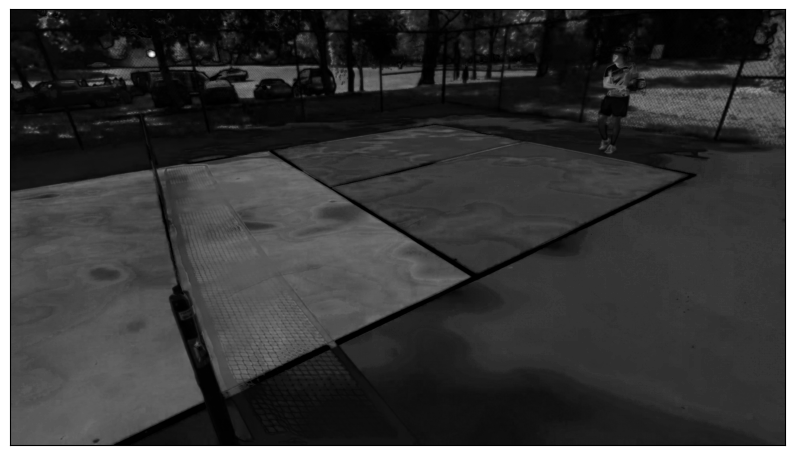

[0.03413667 0.0720663  0.12516778 0.18585519 0.2465426 ]


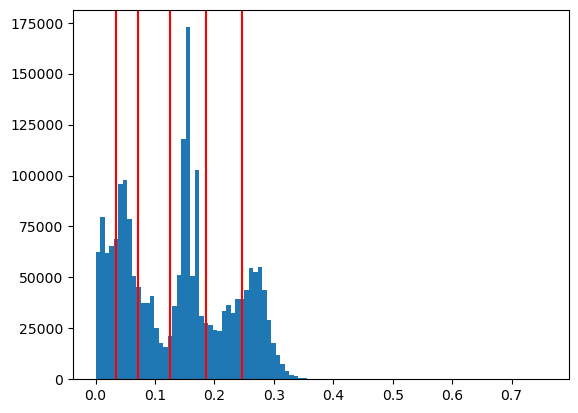

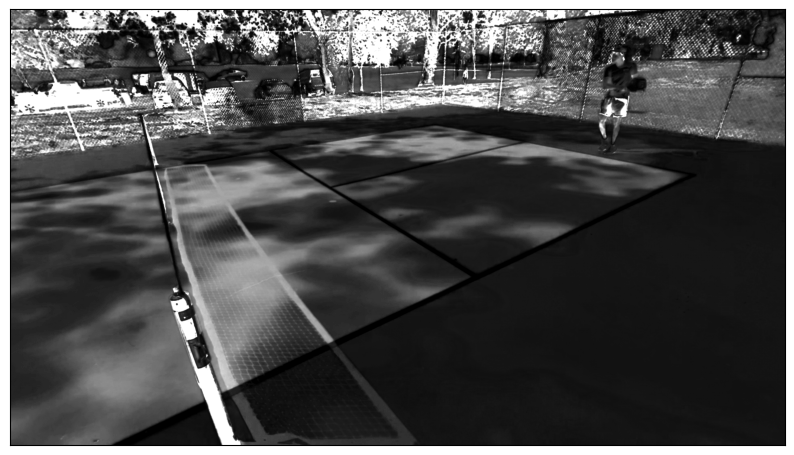

[0.125 0.245 0.385 0.555 0.805]


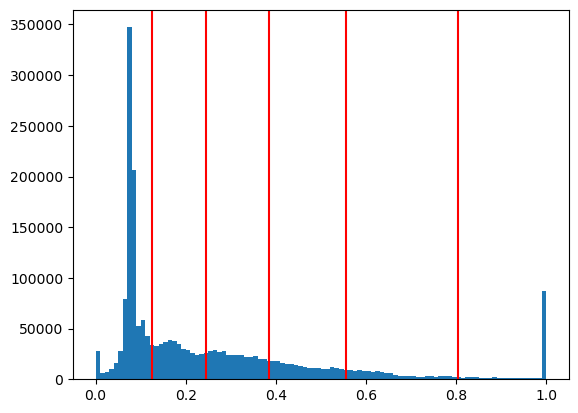

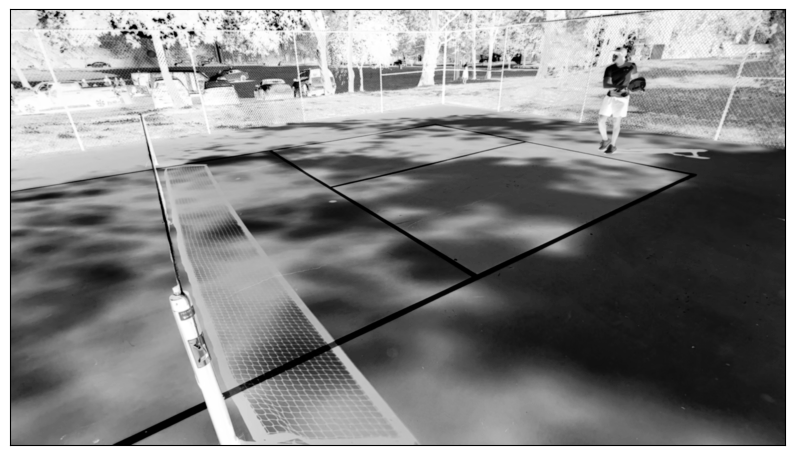

[0.19494495 0.35489977 0.5148546  0.66481225 0.82476708]


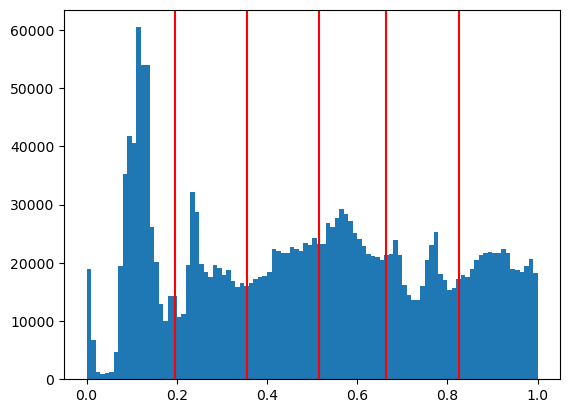

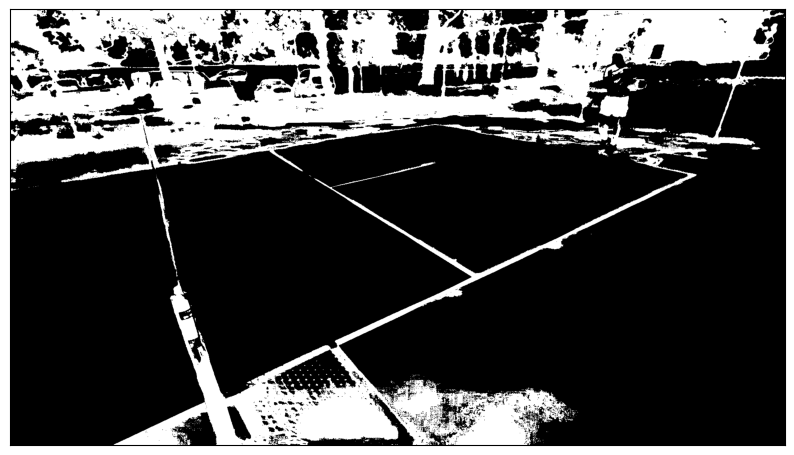

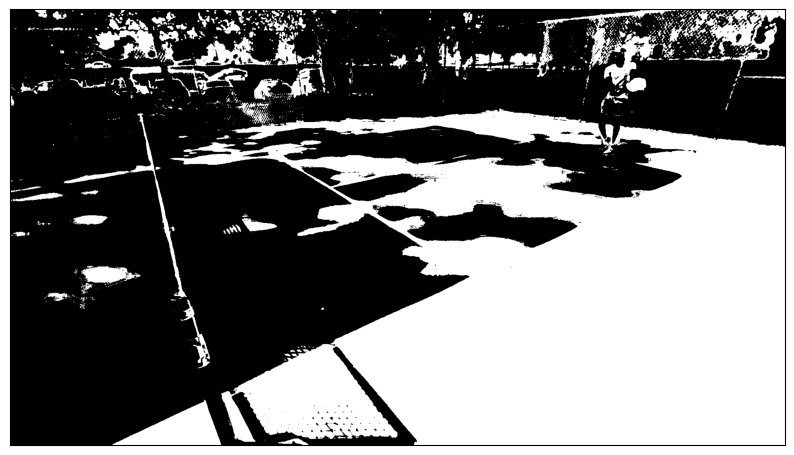

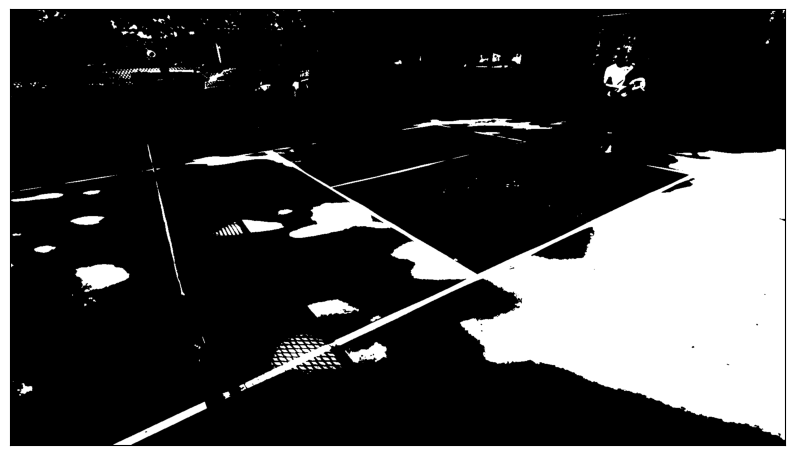

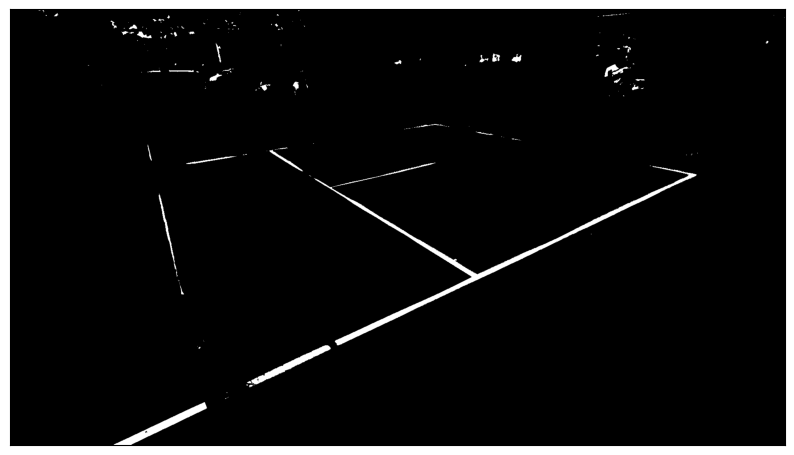

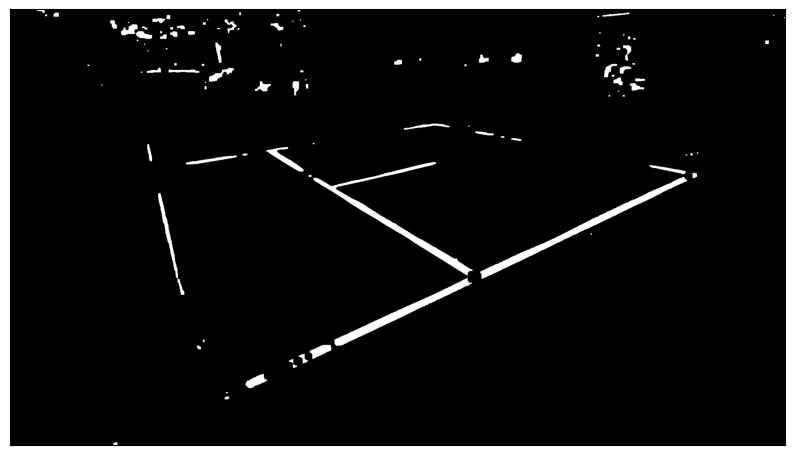

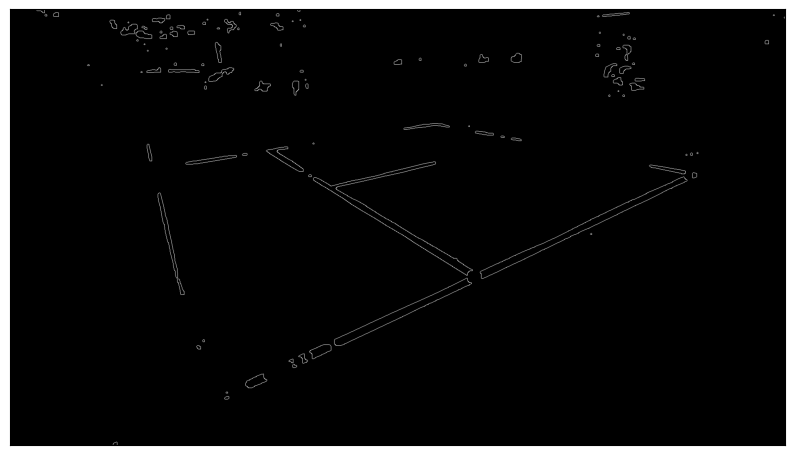

128


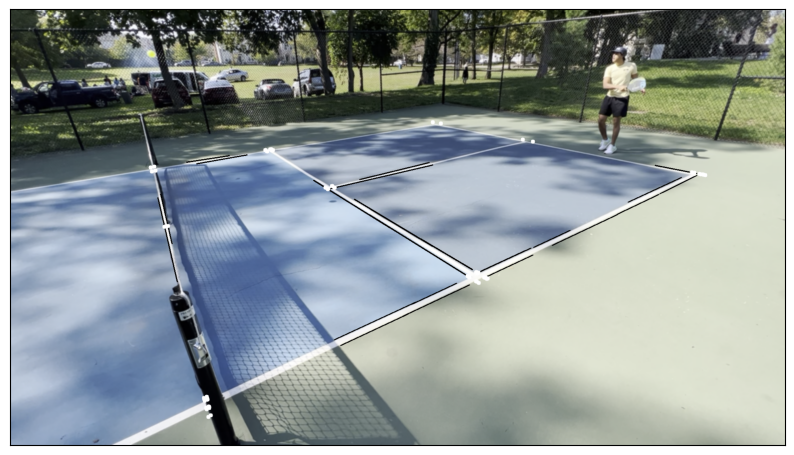

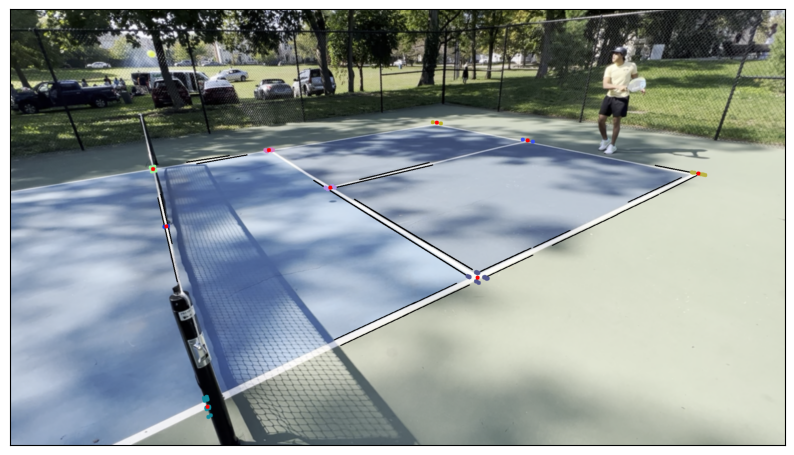

In [171]:
get_predicted_points(img_0, max_threshold=0.05, avg_threshold=0.05, bright_threshold=0.9)